In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import argparse
import yaml
import wandb

import numpy as np
import torch
import torch.nn as nn

from data.dataset import SegmentDataset
from data.transforms import transform
from data.collate import collate
from torch.utils.data import DataLoader
from models.model import SegmentModel
from models.utils.loss import PixelLoss
from metrics.metrics import pixelAccuracy
from metrics.pred import predict
from utils.vis import showPredictions

In [3]:
version = 'v4'
cfg_path = '../configs/{}.yml'.format(version)
all_configs = yaml.safe_load(open(cfg_path))

batch_size = int(all_configs['batch_size'])
num_classes = int(all_configs['num_classes'])
n_epoch = int(all_configs['n_epoch'])
train_annot = all_configs['train_annot']
val_annot = all_configs['val_annot']
n_segment_layers = all_configs['n_segment_layers']
optimizer = all_configs['optimizer']
lr = float(all_configs['lr'])
weight_decay = float(all_configs['weight_decay'])
adam_eps = float(all_configs['adam_eps'])
amsgrad = all_configs['amsgrad']
CHCEKPOINT_DIR = all_configs['CHCEKPOINT_DIR']
ckpt_dir = os.path.join(CHCEKPOINT_DIR, version)
use_augmentation = all_configs['use_augmentation']

In [4]:
model = SegmentModel(num_features=3, n_layers=n_segment_layers).cuda()
criterion = PixelLoss(num_classes=num_classes)

if optimizer=='adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, eps=adam_eps, amsgrad=amsgrad)


In [5]:
train_set = SegmentDataset(annot='../'+train_annot, transform=transform, dim=(2048, 2048))
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=8,
    collate_fn=collate,
)
val_set = SegmentDataset(annot='../'+val_annot, transform=transform, dim=(2048, 2048))
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    num_workers=8,
    collate_fn=collate,
)

In [6]:
def train(epoch, loader, optimizer):
    n = len(loader)
    tot_loss = 0.0

    model.train()
    for batch_idx, (_, _, image, mask) in enumerate(loader):
        y_pred = model(image.cuda())
        image = image.detach().cpu()
        loss = criterion(y_pred, mask.cuda())
        loss.backward()
        optimizer.step()
        y_pred = y_pred.detach().cpu()
        tot_loss += loss.item()

        n_arr = (50*(batch_idx+1))//n
        print('Training : [{}>{}] ({}/{}) loss : {:.4f}, avg_loss : {:.4f}'.format(
            '='*n_arr, '-'*(50-n_arr), (batch_idx+1), n, loss.item(), tot_loss/(batch_idx+1)), end='\r')

    print("\n")
    logg = {
        'training_loss': tot_loss/n,
    }
    return logg


def validate(epoch, loader, optimizer):
    n = len(loader)
    tot_loss = 0.0

    model.eval()
    for batch_idx, (image_path, mask_path, image, mask) in enumerate(loader):
        y_pred = model(image.cuda()).detach().cpu()
        image = image.detach().cpu()
        loss = criterion(y_pred, mask)#.cuda())
        tot_loss += loss.item()

        # y_pred, _ = y_pred.max()
        # acc = pixelAccuracy(y_pred, mask)
        mask_pred = predict(image, model, use_cache=True, params=(y_pred, False))
        showPredictions(image, mask, mask_pred, use_path=False, debug=True, size=(8, 8))

        n_arr = (50*(batch_idx+1))//n
        print('Validation : [{}>{}] ({}/{}) loss : {:.4f}, avg_loss : {:.4f}'.format(
            '='*n_arr, '-'*(50-n_arr), (batch_idx+1), n, loss.item(), tot_loss/(batch_idx+1)), end='\r')

    print("\n")
    logg = {
        'val_loss': tot_loss/n,
    }
    return logg

In [18]:
import matplotlib.pyplot as plt

def showPredictions(imgs, masks, masks_pred, use_path=False, ret='arr', debug=False, size=(8, 8)):
    '''
        Show predictions of model, gt image & gt mask
        imgs: images/paths
        masks: masks/paths
        masks_pred: predicted masks
        ret:    'arr' => array of figures
                'fig' => single figure with subplots of images
        debug :  set True to debug on notebook
    '''
    if use_path:
        imgs = [cv2.imread(img) for img in imgs]
        masks = [cv2.imread(mask) for mask in masks]
    else:
        imgs = [img.permute(1, 2, 0) for img in imgs]

    n = len(imgs)

    if ret=='fig':
        fig, ax = plt.subplots(n, 3, figsize=size)
    elif ret=='arr':
        figs = []

    for i, (img, mask, mask_pred) in enumerate(zip(imgs, masks, masks_pred)):

        if debug:
            fig, ax = plt.subplots(1, 3, figsize=size)
            ax[0].imshow(img)
            ax[0].axis('off')
            ax[1].imshow(mask)
            ax[1].axis('off')
            ax[2].imshow(mask_pred)
            ax[2].axis('off')
            plt.show()

        elif ret=='fig':
            ax[i, 0].imshow(img)
            ax[i, 0].axis('off')
            ax[i, 1].imshow(mask)
            ax[i, 1].axis('off')
            ax[i, 2].imshow(mask_pred)
            ax[i, 2].axis('off')
        elif ret=='arr':
            fig, ax = plt.subplots(1, 3, figsize=size)
            ax[0].imshow(img)
            ax[0].axis('off')
            ax[1].imshow(mask)
            ax[1].axis('off')
            ax[2].imshow(mask_pred)
            ax[2].axis('off')
            figs.append(fig)

    if debug:
        return

    if ret=='arr':
        return figs
    elif ret=='fig':
        return fig

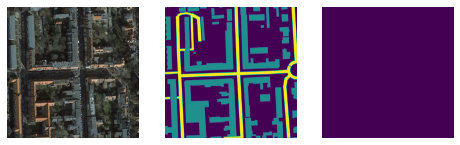

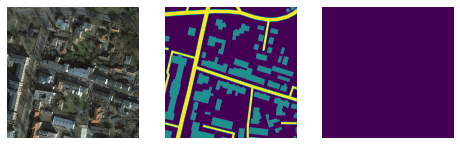

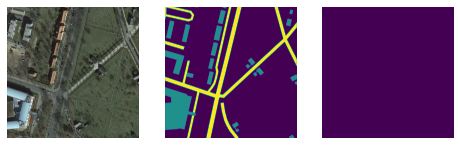

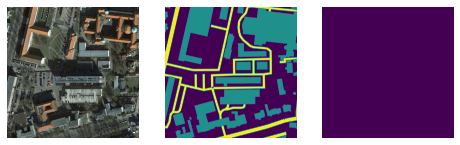

Validation : [==================================================>] (4/4) loss : 1.1606, avg_loss : 1.2124



{'val_loss': 1.212442398071289}

In [19]:
# train(1, train_loader, optimizer)
validate(1, val_loader, optimizer)